Vamos a probar el primer c[odigo] que nos da DRR como introduccion y tratar de analizarlo, de mientras solo necesitamos sacar lasd DRR, pero estar[ia] interesante obtener lo de la segmentacion paritendo de 3D labels.

In [6]:
import torch
print(torch.cuda.get_device_name(0))
print(torch.version.cuda)

NVIDIA GeForce RTX 5080
12.8


Modules

In [7]:
import matplotlib.pyplot as plt
import torch

from diffdrr.drr import DRR
from diffdrr.data import load_example_ct
from diffdrr.visualization import plot_drr

Load of image* how do they upload the volume??

In [28]:
subject = load_example_ct()
print(subject.shape)
print(subject)

(1, 512, 512, 133)
Subject(Keys: ('volume', 'mask', 'orientation', 'reorient', 'density', 'fiducials', 'structures'); images: 3)


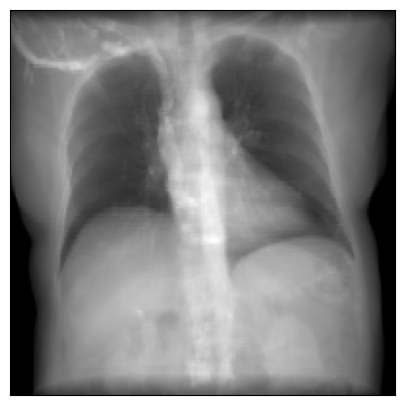

In [ ]:
# Initialize the DRR module for generating synthetic X-rays
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
drr = DRR(
    subject,     # An object storing the CT volume, origin, and voxel spacing
    sdd=1020.0,  # Source-to-detector distance (i.e., focal length)
    height=200,  # Image height (if width is not provided, the generated DRR is square)
    delx=2.0,    # Pixel spacing (in mm).
).to(device)

# Set the camera pose with rotations (yaw, pitch, roll) and translations (x, y, z)
rotations = torch.tensor([[0.0, 0.0, 0.0]], device=device)
translations = torch.tensor([[0.0, 850.0, 0.0]], device=device)

# Also note that DiffDRR can take many representations of SO(3)
# For example, quaternions, rotation matrix, axis-angle, etc...
img = drr(rotations, translations, parameterization="euler_angles", convention="ZXY")
plot_drr(img, ticks=False)
plt.show()

Example to verify functions 

In [12]:
import matplotlib.pyplot as plt
import pyvista
import torch

from diffdrr.data import load_example_ct
from diffdrr.drr import DRR
from diffdrr.pose import convert
from diffdrr.visualization import drr_to_mesh, img_to_mesh, labelmap_to_mesh, plot_drr

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ct = drr_to_mesh(subject, "surface_nets", threshold=225, verbose=True)

Generating label contours: 100%|██████████[00:00<00:00]
Finding and Labeling Connected Regions.: 100%|██████████[00:00<00:00]
Smoothing Mesh using Taubin Smoothing: 100%|██████████[00:01<00:00]
Filling Holes: 100%|██████████[00:00<00:00]
Cleaning: 100%|██████████[00:00<00:00]


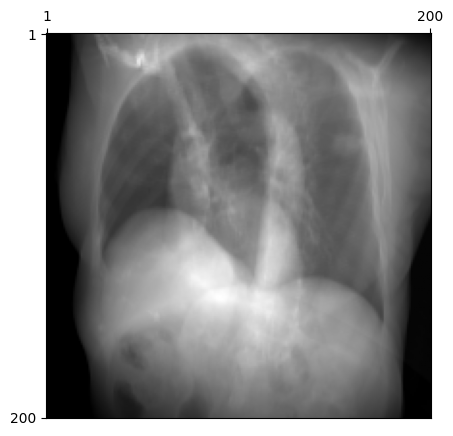

In [13]:
# Initialize the DRR module for generating synthetic X-rays
drr = DRR(subject, sdd=1020.0, height=200, delx=2.0).to(device)

# Make a pose
rot = torch.tensor([[45.0, 30.0, 0.0]], device=device) / 180 * torch.pi
xyz = torch.tensor([[0.0, 800.0, 0.0]], device=device)
pose = convert(rot, xyz, parameterization="euler_angles", convention="ZXY")
plot_drr(drr(pose))
plt.show()

In [14]:
# Make a mesh from the camera and detector plane
camera, detector, texture, principal_ray = img_to_mesh(drr, pose)

# Make the plot
plotter = pyvista.Plotter()
plotter.add_mesh(ct)
plotter.add_mesh(camera, show_edges=True, line_width=1.5)
plotter.add_mesh(principal_ray, color="lime", line_width=3)
plotter.add_mesh(detector, texture=texture)

# Render the plot
plotter.add_axes()
plotter.add_bounding_box()
plotter.show_bounds(grid="front", location="outer", all_edges=True)

# plotter.show()  # If running Jupyter locally
# plotter.show(jupyter_backend="server")  # If running Jupyter remotely
plotter.export_html("render.html")

In [23]:
from IPython.display import IFrame, display
%matplotlib inline
IFrame("render.html", height=500, width=749)
display(IFrame("render.html", height=500, width=749))
# Display the mesh of the camera and detector
